# Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_json('logins.json', typ='frame') 
# settying typ to 'frame' proved unexpectedly key; I needed to be able to reset the stream of timestamps to an index
# and Series objects (default due to single data column) don't let you mess with the index

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [3]:
data.head()

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

In [4]:
data.set_index('login_time', drop=False, inplace=True) # keep a copy of the original column so I can count it during resample
data.head()

login_time
login_time                             
1970-01-01 20:13:18 1970-01-01 20:13:18
1970-01-01 20:16:10 1970-01-01 20:16:10
1970-01-01 20:16:37 1970-01-01 20:16:37
1970-01-01 20:16:36 1970-01-01 20:16:36
1970-01-01 20:26:21 1970-01-01 20:26:21

In [5]:
data15 = data.resample('15T').count()
data15.rename(columns={'login_time':'count'}, inplace=True)
data15.head()

count
login_time                
1970-01-01 20:00:00      2
1970-01-01 20:15:00      6
1970-01-01 20:30:00      9
1970-01-01 20:45:00      7
1970-01-01 21:00:00      1

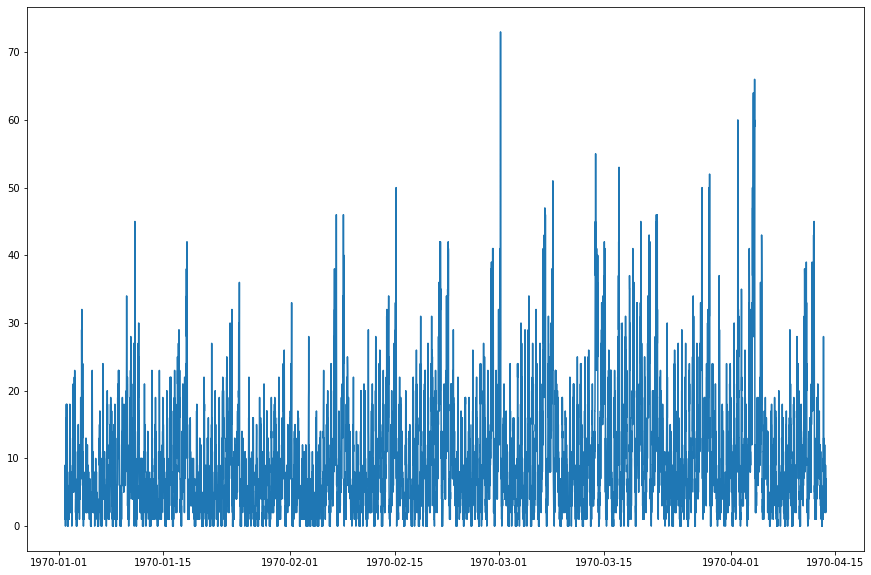

In [6]:
plt.subplots(figsize=(15,10))
plt.plot(data15['count'])
plt.show()

Given that this is supposed to be ride data, I expect it to have a number of different layers of seasonality. I would expect an hourly/time-of-day pattern, a day-of-week pattern, and possibly month or season-of-year shifts in demand. Given that there are four months of data, we wouldn't see if there are changes in demand over summer, fall, or the end-of-year holiday season.

Text(0.5, 1.0, 'Login Counts by Hour of Day')

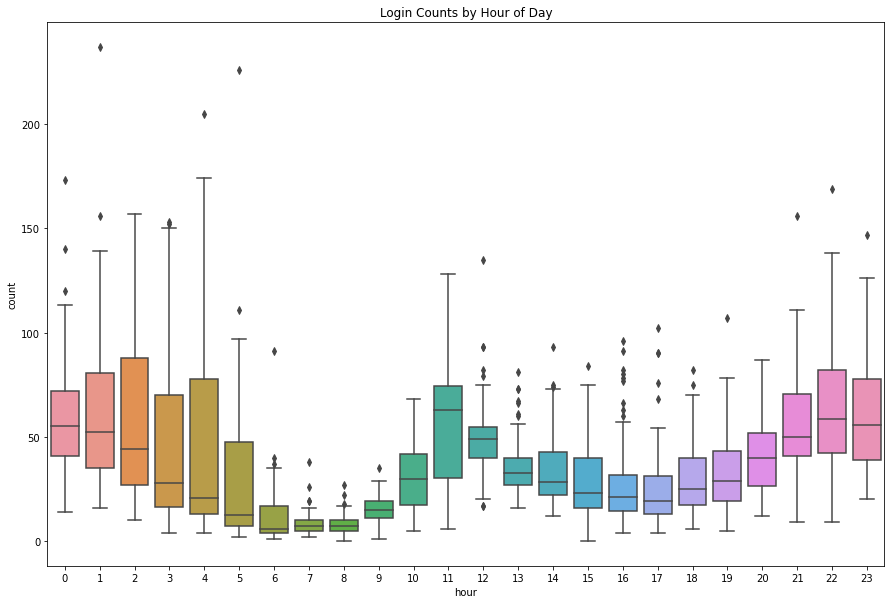

In [14]:
datah = data.resample('60T').count()
datah.rename(columns={'login_time':'count'}, inplace=True)
datah['hour'] = datah.index.hour
plt.subplots(figsize=(15,10))
sns.boxplot(x='hour', y='count', data=datah)
plt.title('Login Counts by Hour of Day')

Plotted hourly, I see a great deal of variability in the midnight to 5AM range, very low counts in the 6-9 AM range (does nobody use this service to get to work?), an odd-looking spike in both demand and variability at 11 AM, and a good deal of evening traffic.

Text(0.5, 1.0, 'Login counts by day of week')

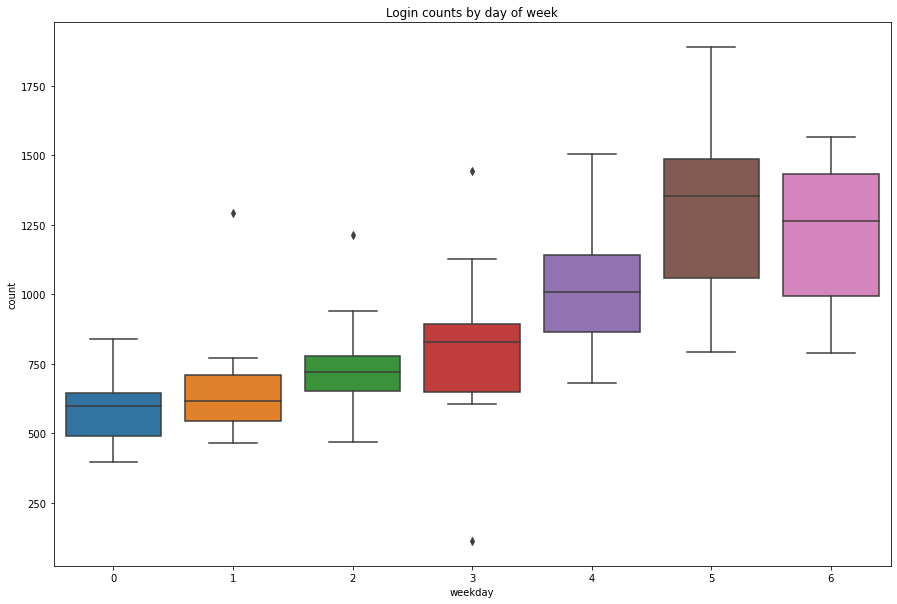

In [15]:
dataw = data.resample('1D').count()
dataw.rename(columns={'login_time':'count'}, inplace=True)
dataw['weekday'] = dataw.index.weekday
plt.subplots(figsize=(15,10))
sns.boxplot(x='weekday', y='count', data=dataw)
plt.title('Login counts by day of week')

Plotted by day of week, my guess that weekends see the most ridership appears confirmed.

Text(0.5, 1.0, 'Login counts by week of year')

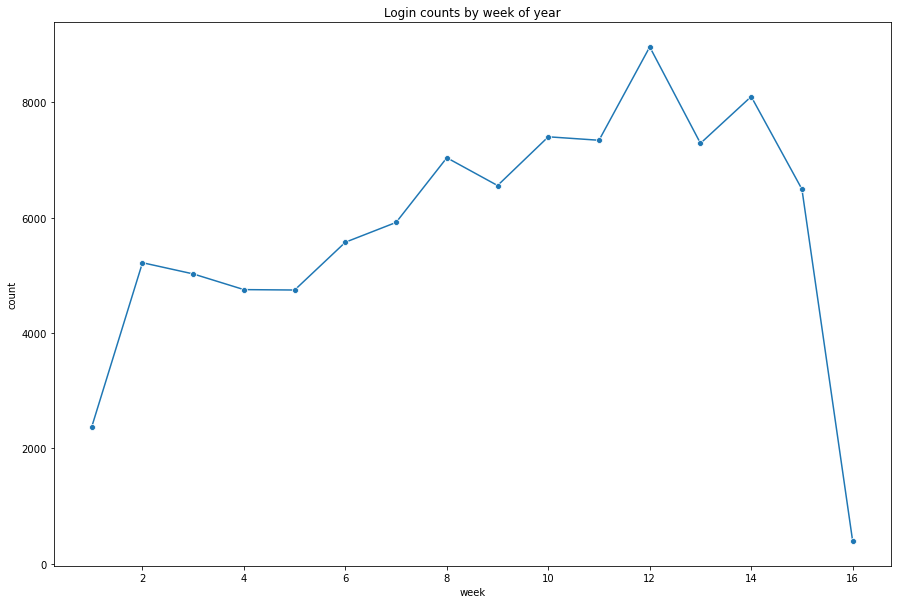

In [17]:
datak = data.resample('1W').count()
datak.rename(columns={'login_time':'count'}, inplace=True)
datak['week'] = pd.Int64Index(datak.index.isocalendar().week)
plt.subplots(figsize=(15,10))
sns.lineplot(x='week', y='count', data=datak, marker='o')
plt.title('Login counts by week of year')

Discounting the first and last weeks which are probably partial, it looks like January is a slow month and then ridership generally trends upward toward April. It might be flattening or just becoming more variable in weeks 12-16, I wouldn't want to guess more without seeing a whole year or better yet multiple years for long-term patterns.

# Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
    * how you will implement the experiment
    * what statistical test(s) you will conduct to verify the significance of the
observation
    * how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

### 1. Key Success Metric
Assuming that Ultimate's driver interface collects data on which cities each driver is available in, I would count the number of drivers offering availability to both cities. If the data are less direct, it might be necessary to create this feature out of information such as each drive's source and destination.

### 2. Experiment Design
* I would collect data for a month prior to the experiment as a baseline, and 